# Plot Results of PLINK
Load PLINK and HAPSBURG Results, and plot them on top of each other
@author Harald Ringbauer, October 2019. 
All rights reserved

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from matplotlib import gridspec
import socket
import os as os
import sys as sys
import multiprocessing as mp
import matplotlib.colors as cls
import h5py

from mpl_toolkits.basemap import Basemap
from matplotlib.patches import Polygon
from matplotlib.collections import PatchCollection

socket_name = socket.gethostname()
print(socket_name)
if socket_name == "VioletQueen":
    path = "/home/harald/git/HAPSBURG/"   # The Path on Harald's machine
elif socket_name.startswith("midway2"):
    print("Midway jnovmbre partition detected.")
    path = "/project2/jnovembre/hringbauer/HAPSBURG/"  # The Path on Midway Cluster
else: 
    raise RuntimeWarning("Not compatible machine. Check!!")
    
os.chdir(path)  # Set the right Path (in line with Atom default)

sys.path.append("./PackagesSupport/h5_python/")
from h5_functions import load_h5

print(os.getcwd()) # Show the current working directory. Should be HAPSBURG/Notebooks/ParallelRuns
print(f"CPU Count: {mp.cpu_count()}")

VioletQueen
/home/harald/git/HAPSBURG
CPU Count: 4


# Plot HAPSBURG ROH vrs PLINK ROH

### Function to load Data

In [15]:
basepath = "./Simulated/1000G_Mosaic/TSI5/ch3_6cm/output/iid0/chr3/"

path_plink_roh = basepath+"plink/roh.csv"
path_h5 = "./Simulated/1000G_Mosaic/TSI5/ch3_6cm/data.h5"

#input_folder = "./Simulated/1000G_Mosaic/TSI/ch3_5cm/output/iid0/chr3/"

df_plink = pd.read_csv(path_plink_roh, sep=",", engine="python")

### Create the Mapping Dictionary
f = load_h5(path=path_h5)
#new_dict = dict(zip(f["variants/POS"], f["variants/MAP"]))

### Create Begin and End Point in Morgan ###Takes about 10s
ob_stat = np.loadtxt(basepath + "hap.csv", dtype="int", delimiter=",")
het = (ob_stat[0,:] != ob_stat[1,:])

gmap = np.loadtxt(basepath + "map.csv", dtype="float", delimiter=",")
df_roh  = pd.read_csv(basepath + "roh_gt.csv", delimiter="\t")

Loaded HDF5
Loaded 77652 variants
Loaded 100 individuals
['AD', 'GT']
['ALT', 'MAP', 'POS', 'REF']


### Plotting Function

In [2]:
def plot_roh_plink_hpbg(df_plink, df_roh, gmap, ob_stat, fs = 14, lw = 8, het_c="blue", post_c="maroon", 
                            cm_lim = [],figsize=(14,2)):
    """Plot ROH inferred from PLINK (df_plink) and HAPSBURG (df_roh)"""
    plt.figure(figsize=figsize)
    ax1=plt.gca()

    ax1.hlines(y=[1.25]*len(df_plink), xmin=100 * df_plink["StartM"], xmax= 100*df_plink["EndM"], 
                    colors="red", linewidth=lw, label="PLINK")

    plt.hlines(y=[1.14]*len(df_roh), xmin=100 * df_roh["ROH_Begin"], xmax= 100 * df_roh["ROH_End"], 
                            colors="green", linewidth=lw, label="HAPSBURG (diploid mode)")

    ax1.set_ylim([-0.09,1.33])
    ax1.plot(gmap*100, (het * 1.1 - 0.05), "o", ms=1, alpha=0.3, zorder=0, color=het_c)
    ax2 = ax1.twinx()
    ax2.set_ylim(ax1.get_ylim())
    ax1.set_yticks([])
    ax2.set_yticks(np.array([1,0]) * 1.1 - 0.05)
    ax2.set_yticklabels([])
    ax1.set_yticklabels([])
    ax2.set_ylabel(f"Het. Genotypes", fontsize=fs*0.9, color=het_c)

    #ax1.set_ylabel("Post. Probability", fontsize=fs, color=post_c)
    ax1.set_xlabel("SNP", fontsize=fs)
    ax1.set_xlabel("CentiMorgan")

    ax1.legend(loc = "center right", title="ROH Calls")

    if len(cm_lim)>0:
        ax1.set_xlim(cm_lim)

    ax1.set_title("1240 Mosaic TSI IID0; 5x4cm ROH", fontsize=fs)
    plt.show()

### Run the Plotting Function

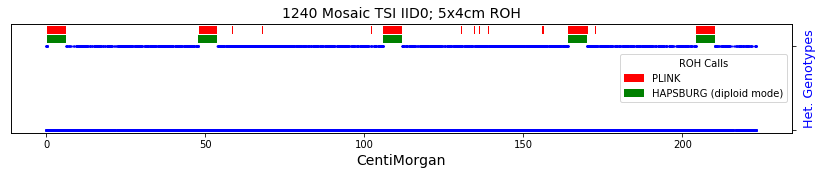

In [19]:
plot_roh_plink_hpbg(df_plink, df_roh, gmap, ob_stat)

# Plot posterior of bcftools/ROH

In [14]:
def plot_posterior_bcftools(df_roh, df_roh_gt, post=[], map_post=[], het=[], het_map=[], 
                            fs = 14, lw = 8, het_c="blue", post_c="maroon", 
                            cm_lim = [],figsize=(14,2), title="", legend=False):
    """Plot ROH inferred from PLINK (df_plink) and HAPSBURG (df_roh).
    Plot data if given (e.g. posterior or heterozygosity)"""
    plt.figure(figsize=figsize)
    ax1=plt.gca()

    ax1.hlines(y=[1.25]*len(df_roh), xmin=100 * df_roh["StartM"], xmax= 100*df_roh["EndM"], 
                    colors="red", linewidth=lw, label="BCF Tools")

    plt.hlines(y=[1.14]*len(df_roh), xmin=100 * df_roh_gt["ROH_Begin"], xmax= 100 * df_roh_gt["ROH_End"], 
                            colors="green", linewidth=lw, label="Ground Truth")
    
    ### Plot the Posterior
    if len(post)>0:
        ax1.plot(map_post*100, np.exp(post), linewidth=2, color=post_c, label="State 0", zorder=1)
    
    ### Plot Heterozygosity
    if len(het)>0:
        ax1.plot(het_map*100, (het * 1.1 - 0.05), "o", ms=1, alpha=0.3, zorder=0, color=het_c)

    ax1.set_ylim([-0.09,1.33])
    ax2 = ax1.twinx()
    ax2.set_ylim(ax1.get_ylim())
    ax1.set_yticks([])
    ax2.set_yticks(np.array([1,0]) * 1.1 - 0.05)
    ax2.set_yticklabels([])
    ax1.set_yticklabels([])
    ax2.set_ylabel(f"Het. Genotypes", fontsize=fs*0.9, color=het_c)

    ax1.set_ylabel("Post. Probability", fontsize=fs, color=post_c)
    ax1.set_xlabel("SNP", fontsize=fs)
    ax1.set_xlabel("CentiMorgan")
    
    if legend:
        ax1.legend(loc = "center right")

    if len(cm_lim)>0:
        ax1.set_xlim(cm_lim)
    
    if len(title)>0:
        ax1.set_title(title, fontsize=fs)
    plt.show()

In [67]:
basepath="./Simulated/1000G_Mosaic/TSI5/ch3_6cm/output/iid1/chr3/"
path_bcf_roh_gt = os.path.join(basepath, "bcftools/roh_gt.csv")
path_bcf_roh = os.path.join(basepath, "bcftools/roh.csv")
path_map_post = os.path.join(basepath, "bcftools/map.csv")
path_post = os.path.join(basepath, "bcftools/posterior0.csv")


df_roh_gt = pd.read_csv(path_bcf_roh_gt, sep="\t", engine="python")
df_roh_bcf =  pd.read_csv(path_bcf_roh, sep=",", engine="python")

post = np.loadtxt(path_post)
post_map = np.loadtxt(path_map_post)

### Create Begin and End Point in Morgan ###Takes about 10s
ob_stat = np.loadtxt(basepath + "hap.csv", dtype="int", delimiter=",")
het = (ob_stat[0,:] != ob_stat[1,:])
het_map = np.loadtxt(basepath + "map.csv", dtype="float", delimiter=",")

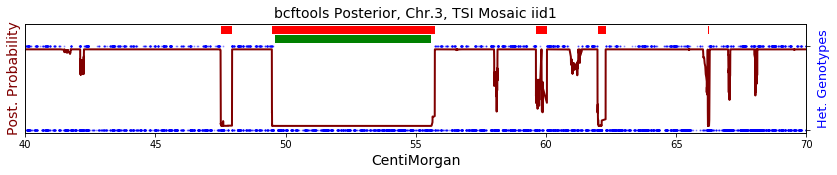

In [75]:
plot_posterior_bcftools(df_roh_bcf, df_roh_gt, post, post_map, het, het_map, cm_lim = [40,70], title="bcftools Posterior, Chr.3, TSI Mosaic iid1")

### Plot the Downsampled RC Posterior

In [11]:
basepath="./Simulated/1000G_Mosaic/TSI5/lambda_rc1.0/ch3_6cm/output/iid0/chr3/"
path_bcf_roh_gt = os.path.join(basepath, "bcftools/roh_gt.csv")
path_bcf_roh = os.path.join(basepath, "bcftools/roh.csv")
#path_map_post = os.path.join(basepath, "bcftools/map.csv")
#path_post = os.path.join(basepath, "bcftools/posterior0.csv")


df_roh_gt = pd.read_csv(path_bcf_roh_gt, sep="\t", engine="python")
df_roh_bcf =  pd.read_csv(path_bcf_roh, sep=",", engine="python")

#post = np.loadtxt(path_post)
#post_map = np.loadtxt(path_map_post)

### Create Begin and End Point in Morgan ###Takes about 10s
ob_stat = np.loadtxt(basepath + "hap.csv", dtype="int", delimiter=",")
het = (ob_stat[0,:] != ob_stat[1,:])
het_map = np.loadtxt(basepath + "map.csv", dtype="float", delimiter=",")

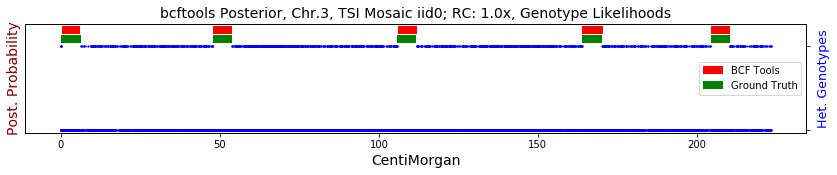

In [16]:
plot_posterior_bcftools(df_roh_bcf, df_roh_gt, cm_lim = [], het=het, het_map=het_map, legend=True,
                        title="bcftools Posterior, Chr.3, TSI Mosaic iid0; RC: 1.0x, Genotype Likelihoods")

# Area 51